# Making predictions with BlazeFace

This notebook shows how to use the model for face detection.

In [1]:
import numpy as np
import torch
import cv2

In [2]:
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())

PyTorch version: 1.5.0+cpu
CUDA version: None
cuDNN version: None


In [3]:
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gpu

device(type='cpu')

Helper code for making plots:

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_detections(img, detections, with_keypoints=True):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.grid(False)
    ax.imshow(img)
    
    if isinstance(detections, torch.Tensor):
        detections = detections.cpu().numpy()

    if detections.ndim == 1:
        detections = np.expand_dims(detections, axis=0)

    print("Found %d faces" % detections.shape[0])
        
    for i in range(detections.shape[0]):
        ymin = detections[i, 0] * img.shape[0]
        xmin = detections[i, 1] * img.shape[1]
        ymax = detections[i, 2] * img.shape[0]
        xmax = detections[i, 3] * img.shape[1]

        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=1, edgecolor="r", facecolor="none", 
                                 alpha=detections[i, 16])
        ax.add_patch(rect)

        if with_keypoints:
            for k in range(6):
                kp_x = detections[i, 4 + k*2    ] * img.shape[1]
                kp_y = detections[i, 4 + k*2 + 1] * img.shape[0]
                circle = patches.Circle((kp_x, kp_y), radius=0.5, linewidth=1, 
                                        edgecolor="lightskyblue", facecolor="none", 
                                        alpha=detections[i, 16])
                ax.add_patch(circle)
        
    plt.show()

## Load the model

In [5]:
from blazeface import BlazeFace

net = BlazeFace().to(gpu)
net.load_weights("blazeface.pth")
net.load_anchors("anchors.npy")

# Optionally change the thresholds:
net.min_score_thresh = 0.75
net.min_suppression_threshold = 0.3

## Make a prediction

The input image should be 128x128. BlazeFace will not automatically resize the image, you have to do this yourself!

In [28]:
img = cv2.imread("../face.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
from PIL import Image
image1 = Image.fromarray(img)
image1 =image1.resize((128,128))
img = np.array(image1)
print(img)

[[[235 235 235]
  [235 235 235]
  [235 235 235]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[231 231 231]
  [231 231 231]
  [231 231 231]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[234 234 234]
  [231 231 231]
  [234 234 234]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[ 13  19  25]
  [ 11  18  24]
  [ 35  40  50]
  ...
  [ 37  33  27]
  [ 40  37  30]
  [ 42  38  32]]

 [[  6  13  19]
  [  2  11  16]
  [ 50  55  64]
  ...
  [ 33  29  22]
  [ 35  32  26]
  [ 35  30  23]]

 [[ 99 103 106]
  [ 96 102 104]
  [127 131 135]
  ...
  [119 116 112]
  [120 118 113]
  [118 115 110]]]


In [29]:
detections = net.predict_on_image(img)
detections.shape

torch.Size([2, 17])

In [30]:
detections

tensor([[ 0.4248, -0.0661,  0.7635,  0.2726,  0.0511,  0.5317,  0.1748,  0.5283,
          0.1272,  0.6231,  0.1273,  0.6806, -0.0281,  0.5526,  0.2268,  0.5427,
          0.9263],
        [ 0.4265,  0.4450,  0.7622,  0.7807,  0.5666,  0.5321,  0.6839,  0.5201,
          0.6428,  0.6176,  0.6436,  0.6803,  0.4860,  0.5586,  0.7287,  0.5331,
          0.9150]])

Found 2 faces


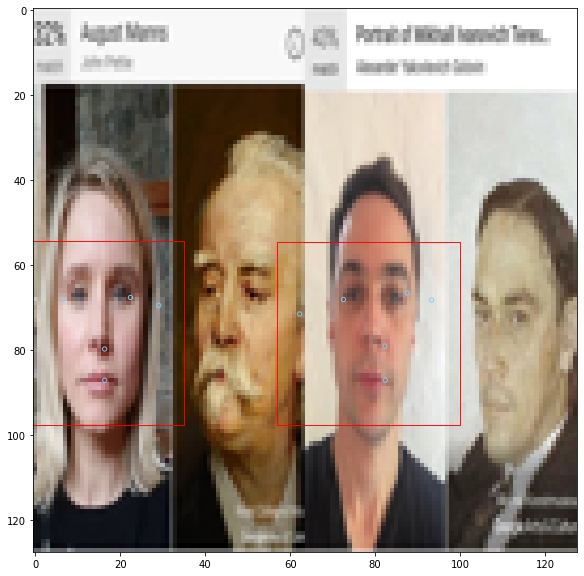

In [31]:
plot_detections(img, detections)

## Make prediction on a batch of images

Load the images into a NumPy array of size `(batch, 128, 128, 3)`. Note: You could also use a PyTorch tensor here, in which case the shape must be `(batch, 3, 128, 128)`.

In [10]:
filenames = [ "1face.png", "3faces.png", "4faces.png" ]

x = np.zeros((len(filenames), 128, 128, 3), dtype=np.uint8)

for i, filename in enumerate(filenames):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x[i] = img

In [11]:
detections = net.predict_on_batch(x)
[d.shape for d in detections]

[torch.Size([1, 17]), torch.Size([3, 17]), torch.Size([0, 17])]

In [12]:
detections

[tensor([[0.2714, 0.3171, 0.4416, 0.4873, 0.3863, 0.3127, 0.4613, 0.3186, 0.4400,
          0.3557, 0.4328, 0.3915, 0.3154, 0.3296, 0.4778, 0.3367, 0.9960]],
        device='cuda:0'),
 tensor([[0.3443, 0.0852, 0.4834, 0.2244, 0.1335, 0.3838, 0.1981, 0.3769, 0.1788,
          0.4125, 0.1769, 0.4428, 0.0832, 0.4031, 0.2211, 0.3888, 0.9991],
         [0.3270, 0.7762, 0.4765, 0.9256, 0.8064, 0.3708, 0.8683, 0.3571, 0.8276,
          0.3952, 0.8355, 0.4299, 0.7934, 0.3984, 0.9291, 0.3740, 0.9968],
         [0.3454, 0.4172, 0.4805, 0.5523, 0.4581, 0.3886, 0.5141, 0.3864, 0.4884,
          0.4244, 0.4891, 0.4475, 0.4259, 0.3933, 0.5457, 0.3888, 0.9245]],
        device='cuda:0'),
 tensor([], size=(0, 17))]

Found 1 faces


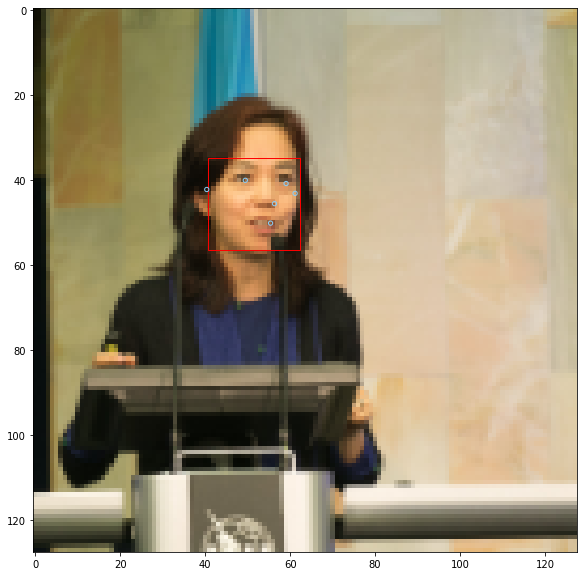

In [13]:
plot_detections(x[0], detections[0])

Found 3 faces


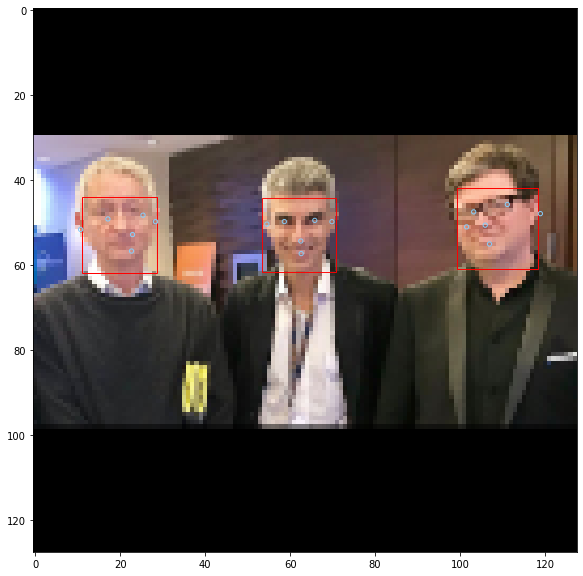

In [14]:
plot_detections(x[1], detections[1])

Found 0 faces


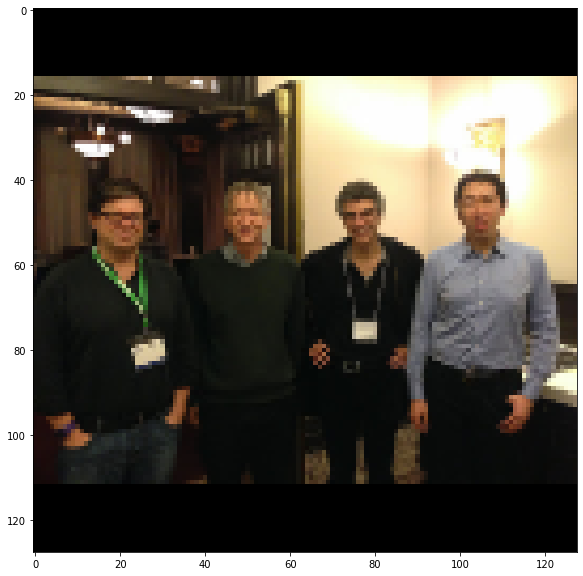

In [15]:
plot_detections(x[2], detections[2])